In [85]:
import geopandas as gpd
import os
import osmnx as ox
import pandas as pd
import requests
from shapely.geometry import Point, LineString
import time


In [80]:
os.getcwd()

'/Users/zorakramer/PATH'

Individual route bounds:
I40E_I25S_Broadway: 0.316 x 0.150 degrees
I40E_98th_RioBravo: 0.295 x 0.093 degrees
I40E_Unser_RioBravo: 0.301 x 0.102 degrees
I40E_Coors_RioBravo: 0.301 x 0.115 degrees
I40W_I25S_Broadway: 0.274 x 0.151 degrees
I40E_SanMateo_Gibson_Broadway: 0.267 x 0.116 degrees

Combined bounds: [-106.94772   34.95711 -106.38696   35.10762]


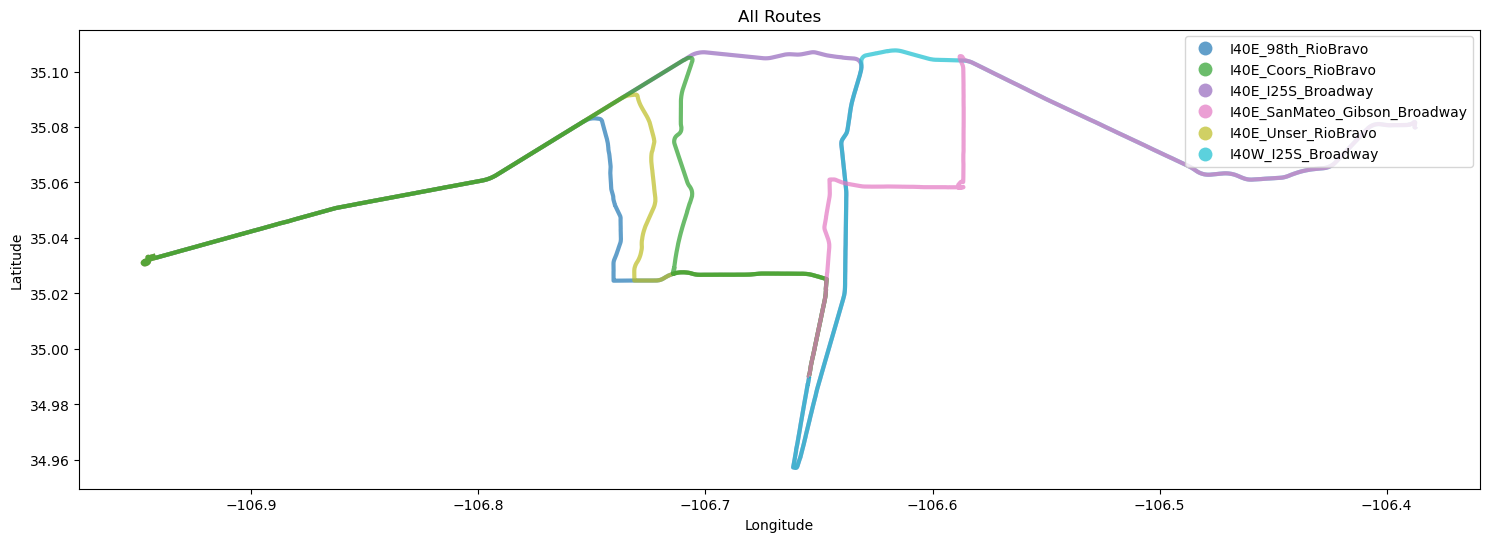

In [74]:
import geopandas as gpd
import matplotlib.pyplot as plt

route_layers = [
    'I40E_I25S_Broadway',
    'I40E_98th_RioBravo', 
    'I40E_Unser_RioBravo',
    'I40E_Coors_RioBravo',
    'I40W_I25S_Broadway',
    'I40E_SanMateo_Gibson_Broadway'
]

all_routes = []
for layer_name in route_layers:
    gdf = gpd.read_file('Routes_Tradeport.kml', 
                        layer=layer_name)
    route = gdf[gdf.geometry.geom_type == 'LineString'].copy()
    route['route_name'] = layer_name
    all_routes.append(route)

routes_gdf = pd.concat(all_routes, ignore_index=True)


print("Individual route bounds:")
for idx, row in routes_gdf.iterrows():
    bounds = row.geometry.bounds
    width = bounds[2] - bounds[0]
    height = bounds[3] - bounds[1]
    print(f"{row['route_name']}: {width:.3f} x {height:.3f} degrees")

print(f"\nCombined bounds: {routes_gdf.total_bounds}")


fig, ax = plt.subplots(figsize=(15, 10))
routes_gdf.plot(ax=ax, column='route_name', legend=True, linewidth=3, alpha=0.7)
plt.title('All Routes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.savefig('routes_overview.png', dpi=150, bbox_inches='tight')
plt.show()

In [149]:
def get_osm_highways_for_bbox(south, north, west, east):
    """OSM Overpass API"""
    overpass_url = "http://overpass-api.de/api/interpreter"
    
    # Query for highways only (much smaller dataset)
    overpass_query = f"""
    [out:json][timeout:180];
    (
      way["highway"~"motorway|trunk|primary|secondary|tertiary|residential|service"]({south},{west},{north},{east});
    );
    (._;>;);
    out body;
    """
     
    print(f"  Querying Overpass API...")
    response = requests.post(overpass_url, data={'data': overpass_query})
    
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f"Overpass API error: {response.status_code}")


In [151]:
route_layers = [
    'I40E_I25S_Broadway',
    'I40E_98th_RioBravo', 
    'I40E_Unser_RioBravo',
    'I40E_Coors_RioBravo',
    'I40W_I25S_Broadway',
    'I40E_SanMateo_Gibson_Broadway'
]

In [153]:
all_routes = []
for layer in route_layers:
    gdf = gpd.read_file('Routes_Tradeport.kml', 
                        layer=layer)
    route = gdf[gdf.geometry.geom_type == 'LineString']
    all_routes.append(route)

routes_combined = pd.concat(all_routes, ignore_index=True)
bounds = routes_combined.total_bounds
buffer = 0.01

south, north = bounds[1] - buffer, bounds[3] + buffer
west, east = bounds[0] - buffer, bounds[2] + buffer

print(f"Downloading OSM data for area: {south:.4f} to {north:.4f}, {west:.4f} to {east:.4f}")
print("This may take 1-2 minutes...")

# Download OSM data
osm_data = get_osm_highways_for_bbox(south, north, west, east)

print(f"✓ Downloaded {len(osm_data['elements'])} OSM elements")

# Parse nodes
osm_nodes = {}
for element in osm_data['elements']:
    if element['type'] == 'node':
        osm_nodes[element['id']] = {
            'node_id': element['id'],
            'lat': element['lat'],
            'lon': element['lon'],
            'geometry': Point(element['lon'], element['lat'])
        }



This may take 1-2 minutes...
  Querying Overpass API...
✓ Downloaded 197824 OSM elements


In [155]:
# roads into links
osm_links = []
for element in osm_data['elements']:
    if element['type'] == 'way':
        node_refs = element['nodes']
        tags = element.get('tags', {})
        
        # Create links between consecutive nodes
        for i in range(len(node_refs) - 1):
            from_node = node_refs[i]
            to_node = node_refs[i + 1]
            
            if from_node in osm_nodes and to_node in osm_nodes:
                from_coords = (osm_nodes[from_node]['lon'], osm_nodes[from_node]['lat'])
                to_coords = (osm_nodes[to_node]['lon'], osm_nodes[to_node]['lat'])
                
                osm_links.append({
                    'link_id': f"{element['id']}_{i}",
                    'way_id': element['id'],
                    'from_node': from_node,
                    'to_node': to_node,
                    'highway': tags.get('highway', ''),
                    'name': tags.get('name', ''),
                    'maxspeed': tags.get('maxspeed', ''),
                    'geometry': LineString([from_coords, to_coords])
                })

#GeoDataFrames
nodes_gdf = gpd.GeoDataFrame(list(osm_nodes.values()), crs='EPSG:4326')
links_gdf = gpd.GeoDataFrame(osm_links, crs='EPSG:4326')

print(f"\n✓ Parsed: {len(nodes_gdf)} OSM nodes, {len(links_gdf)} OSM links")

# Save the full network
nodes_gdf.to_file('osm_nodes_all.geojson', driver='GeoJSON')
links_gdf.to_file('osm_links_all.geojson', driver='GeoJSON')



✓ Parsed: 164096 OSM nodes, 182562 OSM links


In [158]:

for layer_name in route_layers:
    gdf = gpd.read_file('Routes_Tradeport.kml',
                        layer=layer_name)
    kml_route = gdf[gdf.geometry.geom_type == 'LineString'].iloc[0]
    
    route_buffer = kml_route.geometry.buffer(0.001)
    route_links = links_gdf[links_gdf.intersects(route_buffer)].copy()
    
    # Get nodes for those links
    route_node_ids = set(route_links['from_node']) | set(route_links['to_node'])
    route_nodes = nodes_gdf[nodes_gdf['node_id'].isin(route_node_ids)].copy()
    
    route_nodes.to_file(f'{layer_name}_osm_nodes.geojson', driver='GeoJSON')
    route_links.to_file(f'{layer_name}_osm_links.geojson', driver='GeoJSON')
    
    print(f"✓ {layer_name}: {len(route_nodes)} nodes, {len(route_links)} links")


✓ I40E_I25S_Broadway: 3580 nodes, 3605 links
✓ I40E_98th_RioBravo: 2748 nodes, 2914 links
✓ I40E_Unser_RioBravo: 2908 nodes, 3042 links
✓ I40E_Coors_RioBravo: 3604 nodes, 3875 links
✓ I40W_I25S_Broadway: 5805 nodes, 5821 links
✓ I40E_SanMateo_Gibson_Broadway: 6601 nodes, 6891 links

✓✓✓ ALL DONE!


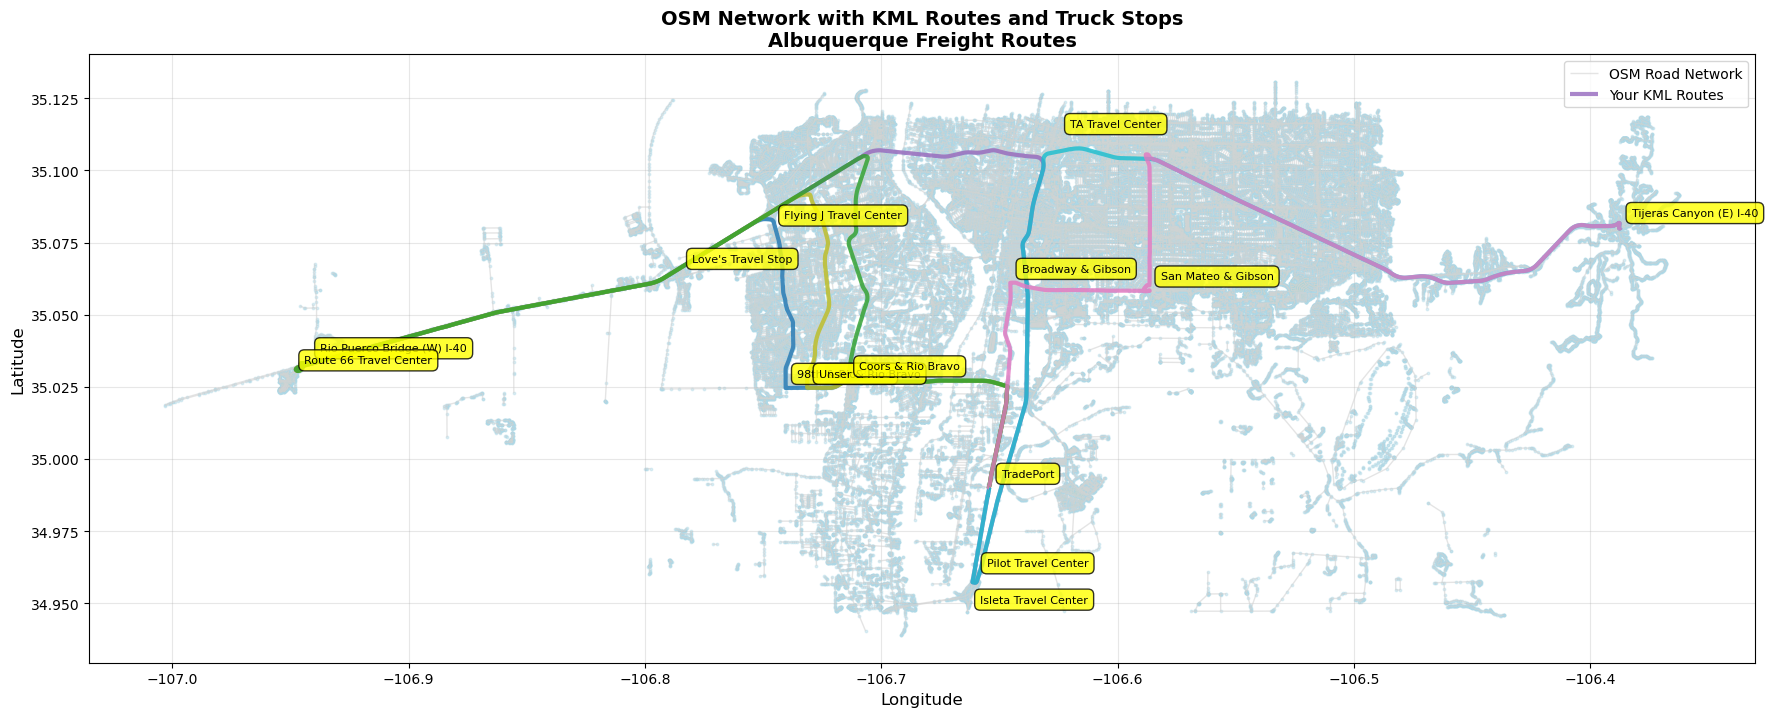

✓ Saved complete network map


In [160]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your data
nodes_all = gpd.read_file('osm_nodes_all.geojson')
links_all = gpd.read_file('osm_links_all.geojson')

# Load your KML routes for comparison
route_layers = [
    'I40E_I25S_Broadway',
    'I40E_98th_RioBravo', 
    'I40E_Unser_RioBravo',
    'I40E_Coors_RioBravo',
    'I40W_I25S_Broadway',
    'I40E_SanMateo_Gibson_Broadway'
]

kml_routes = []
for layer in route_layers:
    gdf = gpd.read_file('Routes_Tradeport.kml', 
                        layer=layer)
    route = gdf[gdf.geometry.geom_type == 'LineString'].copy()
    route['route_name'] = layer
    kml_routes.append(route)

import pandas as pd
kml_routes_gdf = pd.concat(kml_routes, ignore_index=True)

# Create the map
fig, ax = plt.subplots(figsize=(18, 12))

# Plot OSM network (background)
links_all.plot(ax=ax, linewidth=1, color='lightgray', alpha=0.6, label='OSM Road Network')
nodes_all.plot(ax=ax, markersize=3, color='lightblue', alpha=0.4)

# Plot KML routes on top
kml_routes_gdf.plot(ax=ax, column='route_name', linewidth=3, alpha=0.8, 
                    legend=True, cmap='tab10', label='Your KML Routes')


# Add labels for truck stops
for idx, row in truck_stops.iterrows():
    ax.annotate(row['Name'], xy=(row.geometry.x, row.geometry.y), 
                xytext=(8, 8), textcoords='offset points', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8))

ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('OSM Network with KML Routes and Truck Stops\nAlbuquerque Freight Routes', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('complete_network_map.png', dpi=200, bbox_inches='tight')
plt.show()

print("✓ Saved complete network map")

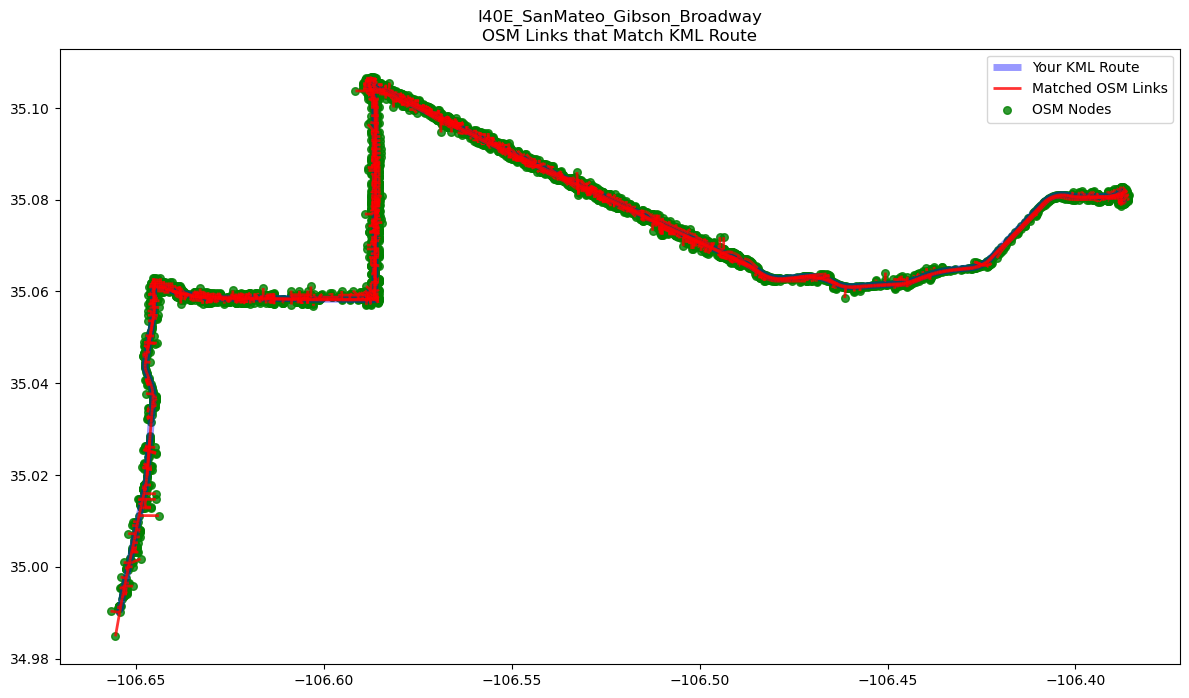

Route: I40E_SanMateo_Gibson_Broadway
OSM Links: 6891
OSM Nodes: 6601

These OSM links are ONLY the ones near your KML route (within 100m buffer)


In [161]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load one route's OSM links
route_name = 'I40E_SanMateo_Gibson_Broadway'
route_osm_links = gpd.read_file(f'{route_name}_osm_links.geojson')
route_osm_nodes = gpd.read_file(f'{route_name}_osm_nodes.geojson')

# Load the original KML route
kml_gdf = gpd.read_file('Routes_Tradeport.kml', 
                        layer=route_name)
kml_route = kml_gdf[kml_gdf.geometry.geom_type == 'LineString'].iloc[0]

# Visualize to confirm
fig, ax = plt.subplots(figsize=(12, 10))

# KML route (your original route)
gpd.GeoDataFrame([kml_route], crs='EPSG:4326').plot(
    ax=ax, linewidth=5, alpha=0.4, color='blue', label='Your KML Route'
)

# OSM links (extracted only for this route)
route_osm_links.plot(ax=ax, linewidth=2, alpha=0.8, color='red', label='Matched OSM Links')

# OSM nodes
route_osm_nodes.plot(ax=ax, markersize=30, color='green', alpha=0.8, label='OSM Nodes')

ax.legend()
ax.set_title(f'{route_name}\nOSM Links that Match KML Route')
plt.tight_layout()
plt.show()

print(f"Route: {route_name}")
print(f"OSM Links: {len(route_osm_links)}")
print(f"OSM Nodes: {len(route_osm_nodes)}")
print(f"\nThese OSM links are ONLY the ones near your KML route (within 100m buffer)")

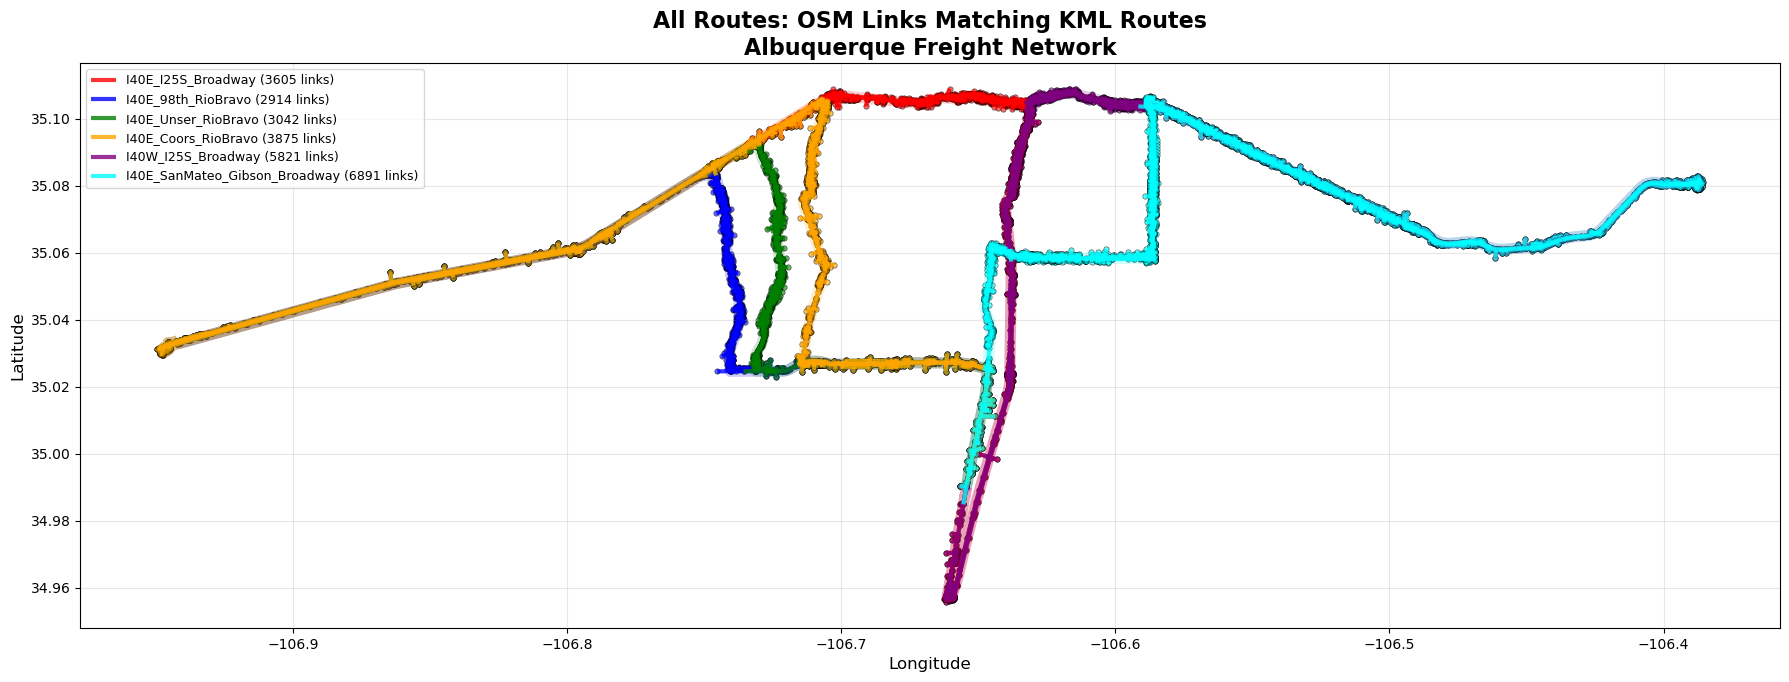

In [164]:
route_layers = [
    'I40E_I25S_Broadway',
    'I40E_98th_RioBravo', 
    'I40E_Unser_RioBravo',
    'I40E_Coors_RioBravo',
    'I40W_I25S_Broadway',
    'I40E_SanMateo_Gibson_Broadway'
]

colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']

fig, ax = plt.subplots(figsize=(18, 12))

# Plot each route's OSM links and nodes
for i, route_name in enumerate(route_layers):
    # Load OSM data for this route
    route_links = gpd.read_file(f'{route_name}_osm_links.geojson')
    route_nodes = gpd.read_file(f'{route_name}_osm_nodes.geojson')
    
    kml_gdf = gpd.read_file('Routes_Tradeport.kml', 
                            layer=route_name)
    kml_route = kml_gdf[kml_gdf.geometry.geom_type == 'LineString']
    
    # Plot KML route (faint)
    kml_route.plot(ax=ax, linewidth=8, alpha=0.2, color=colors[i])
    
    # Plot OSM links (bold)
    route_links.plot(ax=ax, linewidth=3, alpha=0.8, color=colors[i], 
                    label=f'{route_name} ({len(route_links)} links)')
    
    # Plot OSM nodes
    route_nodes.plot(ax=ax, markersize=15, color=colors[i], alpha=0.6, 
                    edgecolor='black', linewidth=0.5)


ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('All Routes: OSM Links Matching KML Routes\nAlbuquerque Freight Network', 
             fontsize=16, fontweight='bold')
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()

plt.show()